In [14]:
import donkeycar as dk
import keras
import h5py
import os
import time
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort
from donkeycar.parts.stores.augmentation import augment, augmented_factor
from random import shuffle

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

In [15]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    result = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        result.append((rec['cam/image_array'], rec['user/angle'], rec['user/throttle']))
    return result

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    result = []
    for p in tub_paths:
        result = result + dataset_from_tub(p, limit=-1)
    return result

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def augment_batch(batch_data):
    for i in range(len(batch_data)):
        batch_data[i] = augment(batch_data[i])

def batch_gen(dataset, batch_size=128, augmented=False):
    while True:
        for i in range(batch_size, len(dataset), batch_size):
            batch = []
            for j in range(-batch_size, 0):
                data = dataset[i+j]
                data = {'cam/image_array': data[0],
                   'user/angle': data[1],
                   'user/throttle': data[2]}
                if augmented:
                    dasta = augment(data)
            
                batch.append(data)
            X = np.array([d['cam/image_array'] for d in batch])
            Y = [np.array([d['user/angle'] for d in batch]), np.array([d['user/throttle'] for d in batch])]
            Y[0] = bin_angle_out(Y[0])
            yield X, Y

In [ ]:
dataset = dataset_from_all_tubs('../../donkeycar/d2/data.ws.pruned')
plt.imshow(dataset[100][0])

Tub does exist
Tub does exist
Tub does exist


In [18]:
BATCH_SIZE=128
SPLIT = 0.8

In [19]:
shuffle(dataset)
split = int(SPLIT * len(dataset))
train_set = dataset[0:split]
val_set = dataset[split:]
train_gen = batch_gen(train_set, augmented=True, batch_size=BATCH_SIZE)
val_gen = batch_gen(val_set, augmented=False, batch_size=BATCH_SIZE)

In [20]:
def classification_model():
    from keras.layers import Input, Dense, merge
    from keras.models import Model
    from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
    from keras.layers import Activation, Dropout, Flatten, Dense

    img_in = Input(shape=(70, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
#     x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(1000, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(400, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)
    x = Dense(100, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)  
    x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)  
    # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0

    #continous output of throttle
    throttle_out = Dense(1, activation='relu', name='throttle_out')(x)      # Reduce to 1 number, Positive number only

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer='rmsprop',
                  loss={'angle_out': 'categorical_crossentropy',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .001})

    return model


In [21]:
save_best = keras.callbacks.ModelCheckpoint("../..//donkeycar/d2/models/test",
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=True,
                                            mode='min')

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=.0005,
                                           patience=5,
                                           verbose=1,
                                           mode='auto')
callbacks_list = [save_best, early_stop]

model = classification_model()
model.fit_generator(train_gen,
                        steps_per_epoch=len(train_set)/BATCH_SIZE,
                        epochs=100,
                        verbose=1,
                        validation_data=val_gen,
                        callbacks=callbacks_list,
                        validation_steps=len(val_set)/BATCH_SIZE)

Epoch 1/100
80/95 [========================>.....] - ETA: 10s - loss: 14.6099 - angle_out_loss: 10.9801 - throttle_out_loss: 4727.7919

KeyboardInterrupt: 

In [8]:
def regression_model():
    from keras.layers import Input, Dense, merge
    from keras.models import Model
    from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
    from keras.layers import Activation, Dropout, Flatten, Dense

    img_in = Input(shape=(120,160,3), name='img_in')
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)

    x = Flatten(name='flattened')(x)
    x = Dense(100, activation='linear')(x)
    x = Dropout(.1)(x)
    x = Dense(50, activation='linear')(x)
    x = Dropout(.1)(x)
    x = Dense(10, activation='linear')(x)
    x = Dropout(.1)(x)
    #categorical output of the angle
    angle_out = Dense(1, activation='linear', name='angle_out')(x)

    #continous output of throttle
    throttle_out = Dense(1, activation='linear', name='throttle_out')(x)

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

    model.compile(optimizer='rmsprop',
                  loss={'angle_out': 'mean_absolute_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 1.0, 'throttle_out': .00})
    return model

In [9]:
save_best = keras.callbacks.ModelCheckpoint("/home/ubuntu/donkeycar/d2/models/ws.nb.newundist",
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=True,
                                            mode='min')

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=.000005,
                                           patience=5,
                                           verbose=1,
                                           mode='auto')

tensor_board = keras.callbacks.TensorBoard(log_dir="/home/ubuntu/donkeycar/d2/logs/{0}".format(time.time()), histogram_freq=1, write_graph=True, write_images=True)

callbacks_list = [save_best, early_stop]

model = regression_model()
model.fit(x=dataset["X"],
          y=dataset["Y"],
          batch_size=128,
          epochs=100,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 27984 samples, validate on 6996 samples
Epoch 1/100
27984/27984 [==============================] - 22s - loss: 1.4349 - angle_out_loss: 1.4349 - throttle_out_loss: 34.7660 - val_loss: 0.1191 - val_angle_out_loss: 0.1191 - val_throttle_out_loss: 0.1311
Epoch 2/100
27984/27984 [==============================] - 20s - loss: 0.0952 - angle_out_loss: 0.0952 - throttle_out_loss: 0.0873 - val_loss: 0.0789 - val_angle_out_loss: 0.0789 - val_throttle_out_loss: 0.1050
Epoch 3/100
27984/27984 [==============================] - 20s - loss: 0.0789 - angle_out_loss: 0.0789 - throttle_out_loss: 0.0796 - val_loss: 0.0791 - val_angle_out_loss: 0.0791 - val_throttle_out_loss: 0.1056
Epoch 4/100
27984/27984 [==============================] - 20s - loss: 0.0738 - angle_out_loss: 0.0738 - throttle_out_loss: 0.0835 - val_loss: 0.1097 - val_angle_out_loss: 0.1097 - val_throttle_out_loss: 0.1211
Epoch 5/100
27984/27984 [==============================] - 19s - loss: 0.0695 - angle_out_loss: 0.0695 - t

In [6]:
binned_dataset["X"] = binned_dataset["X"]/127.5 - 1
binned_dataset["X"]

array([[[[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        ..., 
        [[-0.12941176, -0.12156863,

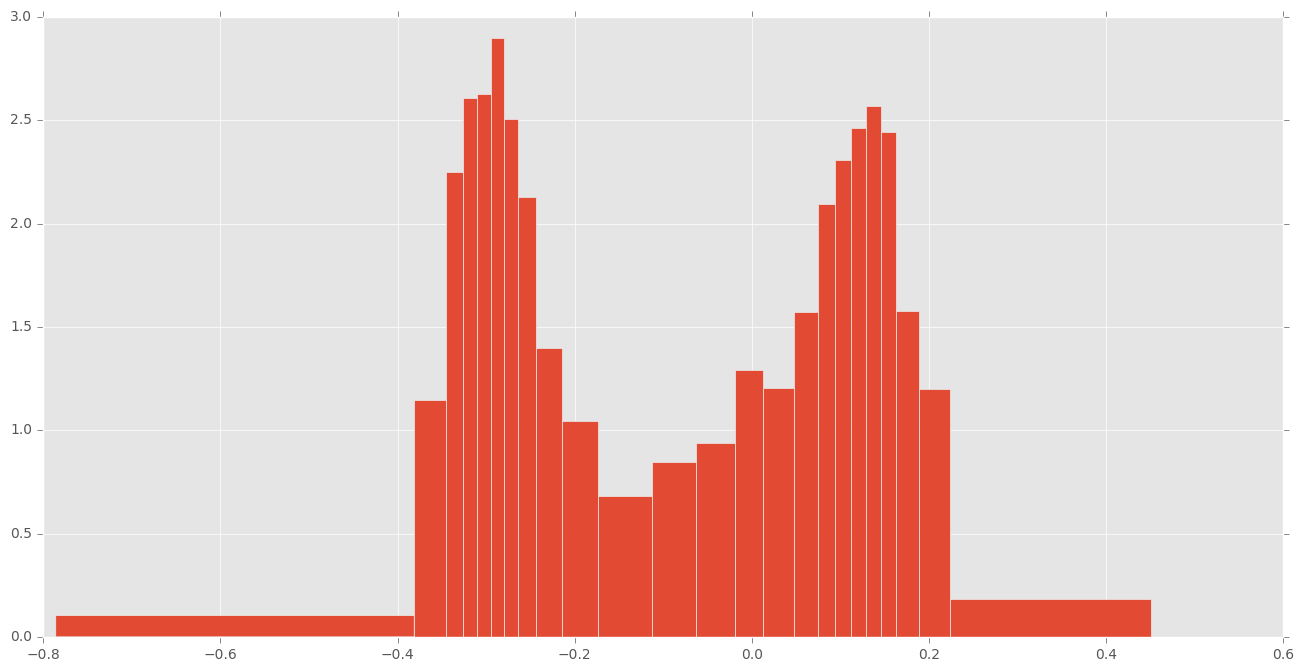

In [7]:
edges = np.percentile(dataset["Y"]["angle_out"], np.linspace(0, 100, 25))
plt.hist(dataset["Y"]["angle_out"], bins=edges, normed=True)
digits = np.digitize(dataset["Y"]["angle_out"], bins=edges)
def bin_it(i):
    r = np.zeros(25)
    r[i-1] = 1
    return r

binned = np.asarray([bin_it(i) for i in digits], dtype="float64")

In [8]:
binned_dataset["Y"] = dataset["Y"]
binned_dataset["Y"]["angle_out"] = binned

model.summary()